<Figure size 1500x1000 with 0 Axes>

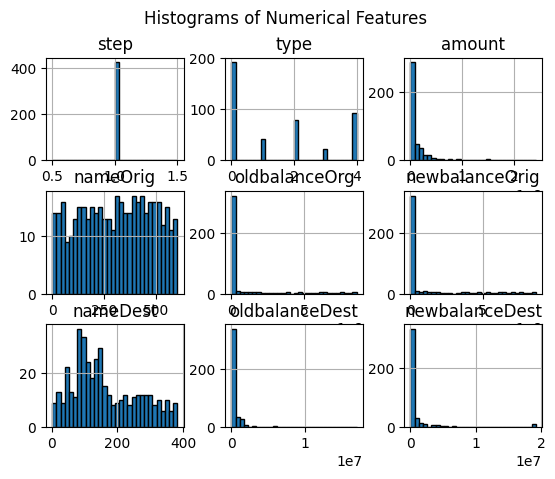

<Figure size 1500x1000 with 0 Axes>

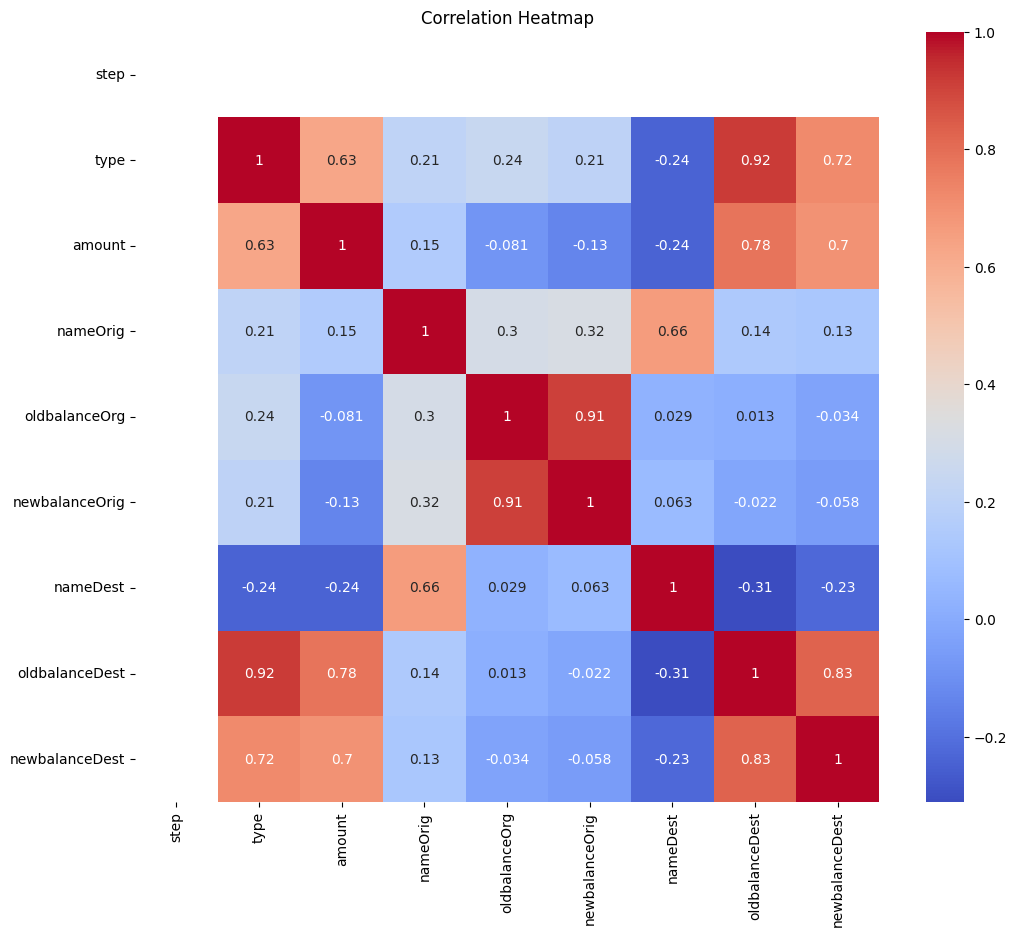

In [22]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('data.csv')

# Encode categorical variables using factorize before splitting to handle unseen categories
for col in df.select_dtypes(include=['object']).columns:
    df[col], _ = pd.factorize(df[col])

# Separate features by type
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop(['isFraud', 'isFlaggedFraud'])
cat_columns = df.select_dtypes(include=['object']).columns

# Handle missing values and convert 'isFraud' to int before splitting
df['isFraud'] = df['isFraud'].fillna(0).astype(int)

# Splitting the dataset into training and testing sets
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply KNN Imputer to handle missing values for numerical columns
imputer = KNNImputer(n_neighbors=5)
X_train[num_columns] = imputer.fit_transform(X_train[num_columns])
X_test[num_columns] = imputer.transform(X_test[num_columns])

# Visualize the distribution of numerical features
plt.figure(figsize=(15, 10))
X_train[num_columns].hist(bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Visualize the distribution of categorical features
plt.figure(figsize=(15, 10))
for index, col in enumerate(cat_columns):
    plt.subplot(len(cat_columns), 1, index + 1)
    X_train[col].value_counts().plot(kind='bar')
    plt.title(col)
plt.tight_layout()
plt.show()

# Apply Power Transformer for numerical feature scaling and transformation
pt = PowerTransformer()
X_train[num_columns] = pt.fit_transform(X_train[num_columns])
X_test[num_columns] = pt.transform(X_test[num_columns])

# Visualize the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(X_train, columns=X.columns).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Adjust k_neighbors in SMOTE based on the smallest class count in the training data
min_class_count = y_train.value_counts().min()
k_neighbors = max(2, min(5, min_class_count - 1))  # at least 2 neighbors to avoid errors

# Handling the imbalanced dataset with SMOTE in training data
smote = SMOTE(k_neighbors=k_neighbors)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# The data is now preprocessed and ready for modeling


Epoch 1/50
3/3 [==============================] - 1s 64ms/step - loss: 0.1355 - val_loss: 0.1192
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 0.1327 - val_loss: 0.1166
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 0.1301 - val_loss: 0.1140
Epoch 4/50
3/3 [==============================] - 0s 28ms/step - loss: 0.1274 - val_loss: 0.1114
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.1248 - val_loss: 0.1088
Epoch 6/50
3/3 [==============================] - 0s 29ms/step - loss: 0.1223 - val_loss: 0.1062
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: 0.1197 - val_loss: 0.1036
Epoch 8/50
3/3 [==============================] - 0s 32ms/step - loss: 0.1172 - val_loss: 0.1010
Epoch 9/50
3/3 [==============================] - 0s 22ms/step - loss: 0.1146 - val_loss: 0.0983
Epoch 10/50
3/3 [==============================] - 0s 23ms/step - loss: 0.1121 - val_loss: 0.0957
Epoch 11/50
3/3 [============

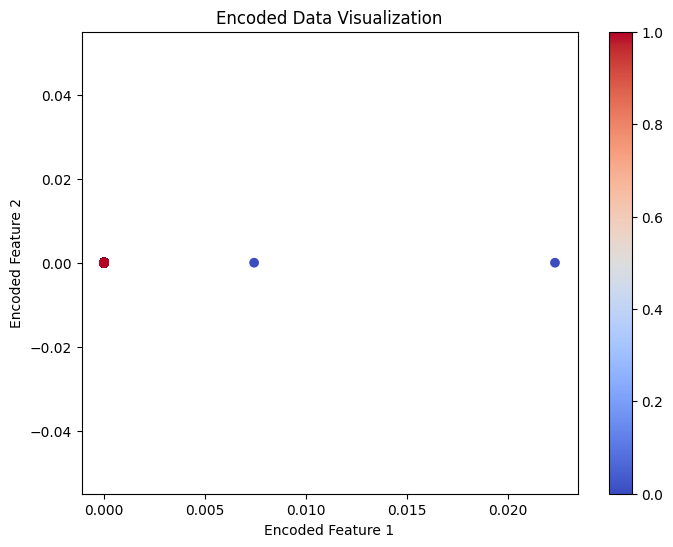

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Assuming X_train_sm is the preprocessed data from previous steps

# Normalize data for Autoencoder
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train_sm)

# Define the autoencoder structure
input_dim = X_scaled.shape[1]  # Number of features
encoding_dim = 32  # Number of neurons in the encoding layer, can be adjusted

# Input Layer
input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the Model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Use Encoder part of the Autoencoder for Feature Extraction
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_features = encoder_model.predict(X_scaled)

# Visualizing the Encoded Data (Reduced Features)
plt.figure(figsize=(8, 6))
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=y_train_sm, cmap='coolwarm')
plt.colorbar()
plt.title('Encoded Data Visualization')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.show()


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_sm, y_train_sm)
model_filename = 'random_forest_model.h5'
joblib.dump(rf_model, model_filename)

rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy}')


Random Forest Accuracy: 0.989010989010989


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train_sm, y_train_sm)
gb_predictions = gb_model.predict(X_test)

# Evaluate the model
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f'Gradient Boosting Accuracy: {gb_accuracy}')


Gradient Boosting Accuracy: 0.989010989010989


In [26]:
# import xgboost as xgb

# # XGBoost model
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# xgb_model.fit(X_train_sm, y_train_sm)
# xgb_predictions = xgb_model.predict(X_test)

# # Evaluate the model
# xgb_accuracy = accuracy_score(y_test, xgb_predictions)
# print(f'XGBoost Accuracy: {xgb_accuracy}')


In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert DataFrame to NumPy array
X_train_array = X_train_sm.to_numpy()

# Reshape input to be 3D [samples, timesteps, features] for LSTM
timesteps = 1
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], timesteps, X_train_array.shape[1]))

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_reshaped, y_train_sm, epochs=10, batch_size=32)


Epoch 1/10
27/27 [==============================] - 3s 5ms/step - loss: 0.3197
Epoch 2/10
27/27 [==============================] - 0s 5ms/step - loss: 0.1198
Epoch 3/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0717
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 5/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 6/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 7/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0257
Epoch 8/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 9/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0205
Epoch 10/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0186


In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Convert DataFrame to NumPy array
X_train_array = X_train_sm.to_numpy()

# Reshape input to be 3D [samples, timesteps, features] for CNN
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

# CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_reshaped, y_train_sm, epochs=10, batch_size=32)


Epoch 1/10
27/27 [==============================] - 1s 3ms/step - loss: 0.5318 - accuracy: 0.8492
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.2918 - accuracy: 0.9454
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.9608
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9822
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9881
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0368 - accuracy: 0.9952
Epoch 7/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0280 - accuracy: 0.9952
Epoch 8/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9964
Epoch 9/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9964
Epoch 10/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 0.9964


Epoch 1/10
22/22 [==============================] - 1s 24ms/step - loss: 0.0113 - accuracy: 0.9985 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 2/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 0.0087 - accuracy: 0.9985 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 5/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 6/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 7/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 8/10
22/22 [=

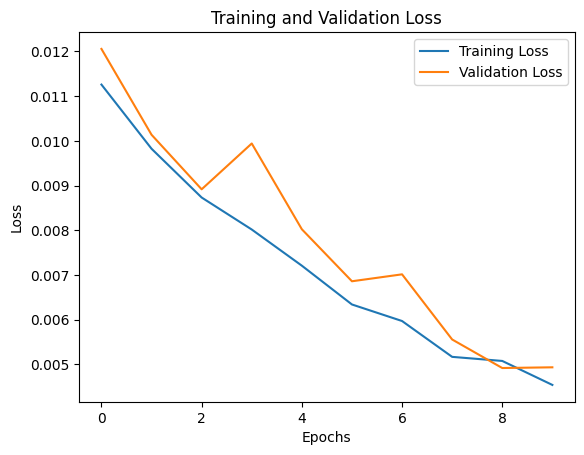

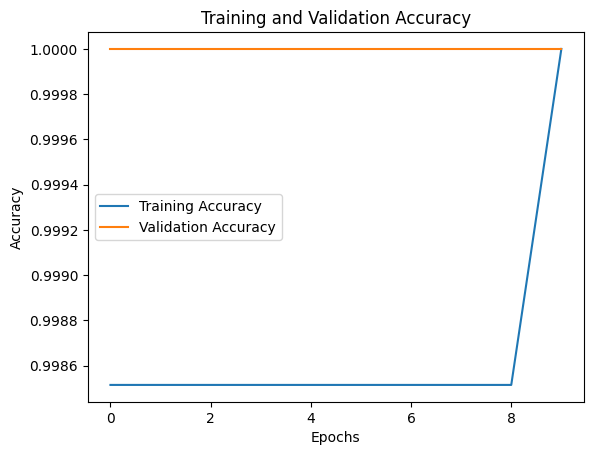

In [12]:
import matplotlib.pyplot as plt

# Train the model and store history for plotting
history = cnn_model.fit(X_train_reshaped, y_train_sm, epochs=10, batch_size=32, validation_split=0.2)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


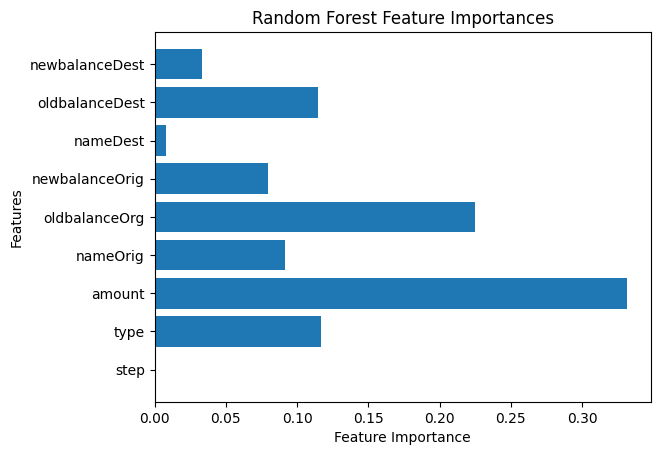

Random Forest Accuracy: 0.989010989010989
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       181
           1       0.00      0.00      0.00         1

    accuracy                           0.99       182
   macro avg       0.50      0.50      0.50       182
weighted avg       0.99      0.99      0.99       182



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_train_sm, y_train_sm)

# Plot feature importances
plt.barh(X_train_sm.columns, rf_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()

# Make predictions
rf_preds = rf_model.predict(X_test)

# Evaluate model performance
print('Random Forest Accuracy:', accuracy_score(y_test, rf_preds))
print('Random Forest Classification Report:')
print(classification_report(y_test, rf_preds))


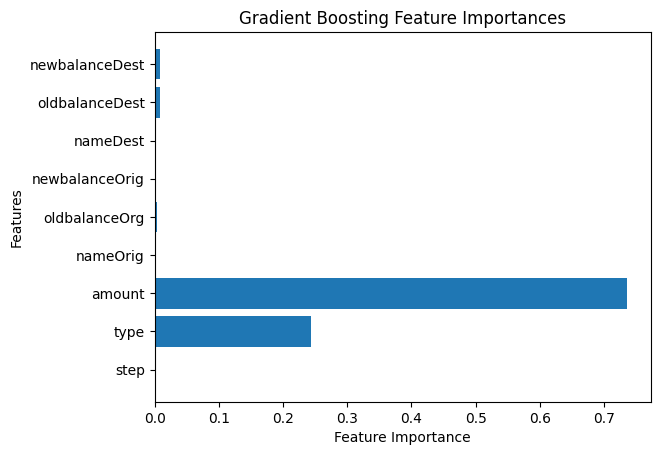

Gradient Boosting Accuracy: 0.989010989010989
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       181
           1       0.33      1.00      0.50         1

    accuracy                           0.99       182
   macro avg       0.67      0.99      0.75       182
weighted avg       1.00      0.99      0.99       182



In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gb_model = GradientBoostingClassifier()

# Fit the model
gb_model.fit(X_train_sm, y_train_sm)

# Plot feature importances
plt.barh(X_train_sm.columns, gb_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importances')
plt.show()

# Make predictions
gb_preds = gb_model.predict(X_test)

# Evaluate model performance
print('Gradient Boosting Accuracy:', accuracy_score(y_test, gb_preds))
print('Gradient Boosting Classification Report:')
print(classification_report(y_test, gb_preds))


In [15]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model
isolation_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit the model on training data
isolation_forest.fit(X_train)

# Predict outliers/anomalies
outliers_preds = isolation_forest.predict(X_test)

# Anomaly detection results
anomalies = X_test[outliers_preds == -1]

# Visualize anomalies or perform further analysis
# For example, you can print the number of anomalies detected
print('Number of anomalies detected:', len(anomalies))


Number of anomalies detected: 20


In [17]:
from sklearn.svm import OneClassSVM

# Initialize One-Class SVM model
one_class_svm = OneClassSVM(nu=0.1)

# Fit the model on training data (normal instances only)
one_class_svm.fit(X_train)

# Predict outliers/anomalies
outliers_preds = one_class_svm.predict(X_test)

# Anomaly detection results
anomalies = X_test[outliers_preds == -1]

# Visualize anomalies or perform further analysis
# For example, you can print the number of anomalies detected
print('Number of anomalies detected:', len(anomalies))


Number of anomalies detected: 25


C:\Users\adilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adi

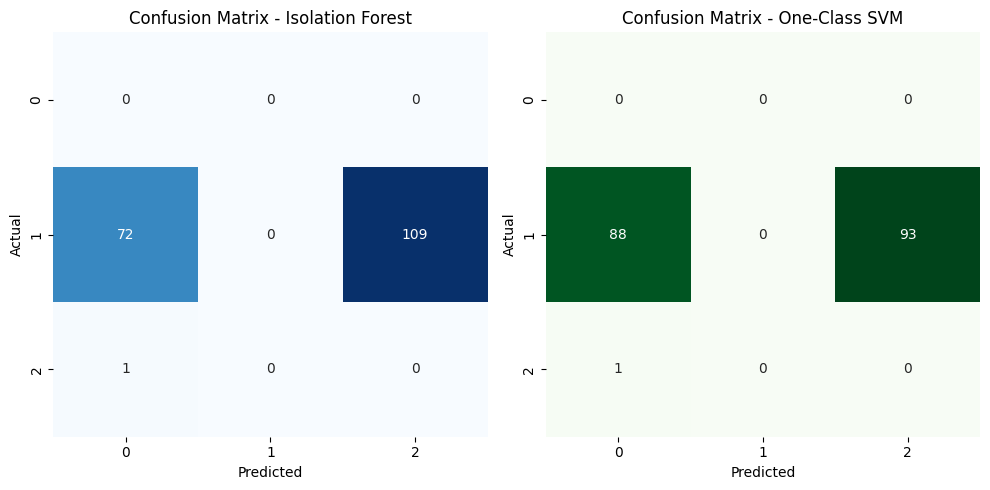

Evaluation Metrics - Isolation Forest:
Accuracy: 0.0000
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Evaluation Metrics - One-Class SVM:
Accuracy: 0.0000
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


In [21]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, and y_test are defined and contain the preprocessed data and labels

# Define and fit Isolation Forest model
isolation_forest_model = IsolationForest(random_state=42)
isolation_forest_model.fit(X_train)

# Define and fit One-Class SVM model
one_class_svm_model = OneClassSVM()
one_class_svm_model.fit(X_train)

# Predictions using Isolation Forest
if_preds = isolation_forest_model.predict(X_test)

# Predictions using One-Class SVM
svm_preds = one_class_svm_model.predict(X_test)

# Evaluation Metrics
accuracy_if = accuracy_score(y_test, if_preds)
f1_if = f1_score(y_test, if_preds, average='weighted')  # Use 'weighted' for multiclass
precision_if = precision_score(y_test, if_preds, average='weighted')  # Use 'weighted' for multiclass
recall_if = recall_score(y_test, if_preds, average='weighted')  # Use 'weighted' for multiclass

accuracy_svm = accuracy_score(y_test, svm_preds)
f1_svm = f1_score(y_test, svm_preds, average='weighted')  # Use 'weighted' for multiclass
precision_svm = precision_score(y_test, svm_preds, average='weighted')  # Use 'weighted' for multiclass
recall_svm = recall_score(y_test, svm_preds, average='weighted')  # Use 'weighted' for multiclass

# Confusion Matrix for Isolation Forest
cm_if = confusion_matrix(y_test, if_preds)

# Confusion Matrix for One-Class SVM
cm_svm = confusion_matrix(y_test, svm_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_if, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print Evaluation Metrics
print('Evaluation Metrics - Isolation Forest:')
print(f'Accuracy: {accuracy_if:.4f}')
print(f'F1 Score: {f1_if:.4f}')
print(f'Precision: {precision_if:.4f}')
print(f'Recall: {recall_if:.4f}')

print('\nEvaluation Metrics - One-Class SVM:')
print(f'Accuracy: {accuracy_svm:.4f}')
print(f'F1 Score: {f1_svm:.4f}')
print(f'Precision: {precision_svm:.4f}')
print(f'Recall: {recall_svm:.4f}')
